In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [69]:
# Load data
df = pd.read_csv(
        "/Users/kanadb/Work/IIT-KGP Summer/cancer-research/datasets/UCSC-Xena-RNA-Seq-Gene-Expression-IlluminaHiSeq/TCGA.BRCA.sampleMap_HiSeqV2", 
        sep='\t',
        index_col=0
    )

print(df.shape)
df.head()

(20530, 1218)


,TCGA-AR-A5QQ-01,TCGA-D8-A1JA-01,TCGA-BH-A0BQ-01,TCGA-BH-A0BT-01,TCGA-A8-A06X-01,TCGA-A8-A096-01,TCGA-BH-A0C7-01,TCGA-AC-A5XU-01,TCGA-PE-A5DE-01,TCGA-PE-A5DC-01,...,TCGA-A7-A13E-11,TCGA-C8-A8HP-01,TCGA-E9-A5FL-01,TCGA-AC-A2FB-11,TCGA-E2-A15F-01,TCGA-A2-A3XT-01,TCGA-B6-A0X7-01,TCGA-BH-A1EV-11,TCGA-3C-AALJ-01,TCGA-B6-A0X1-01
sample,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,9.5074,7.4346,9.3216,9.0198,9.6417,9.7665,10.0931,9.1524,9.9398,9.6287,...,9.6265,10.1826,9.9199,9.9090,10.0334,11.5144,10.5745,9.4048,10.9468,10.3164
HIF3A,1.5787,3.6607,2.7224,1.3414,0.5819,0.2738,3.6090,0.4738,2.9378,4.1136,...,8.1546,2.2159,3.8645,8.1872,0.8836,1.3169,4.0696,7.2537,0.9310,2.4191
RNF17,0.0000,0.6245,0.5526,0.0000,0.0000,0.8765,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,3.7305,0.0000,0.0000,1.1329,0.4258,0.0000,0.0000,0.0000
RNF10,11.3676,11.9181,11.9665,13.1881,12.0036,11.8118,11.3820,11.5004,12.2055,12.1312,...,11.9869,12.2653,12.4815,11.8263,12.0135,11.5818,11.8663,11.5460,12.2616,12.1570
RNF11,11.1292,13.5273,11.4105,11.0911,11.2545,10.8554,10.7663,10.4358,11.2210,10.8013,...,11.9344,11.4117,10.4902,11.5754,10.8370,10.2736,10.7644,11.8774,10.7842,11.2420


In [70]:
# Convert all values to float, set non-numeric values to NaN
df = df.apply(pd.to_numeric, errors='coerce')

In [71]:
# Normal samples
normal_cols = [col for col in df.columns if col.endswith("11")]
normal_count = len(normal_cols)

# Tumor samples
tumor_cols = [col for col in df.columns if col.endswith("01")]
tumor_count = len(tumor_cols)

print(f"Number of Normal samples: {normal_count}")
print(f"Number of Tumor samples: {tumor_count}")

Number of Normal samples: 114
Number of Tumor samples: 1097


In [72]:
# Other Columns
other_cols = [col for col in df.columns if not col.endswith("11") and not col.endswith("01")]
other_cols

['TCGA-E2-A15A-06',
 'TCGA-BH-A18V-06',
 'TCGA-E2-A15K-06',
 'TCGA-AC-A6IX-06',
 'TCGA-E2-A15E-06',
 'TCGA-BH-A1ES-06',
 'TCGA-BH-A1FE-06']

In [73]:
# Extract sample base names (first 3 parts of TCGA barcode)
# TCGA barcode: TCGA-XX-YYYY-99
# Match samples with same first 3 parts: TCGA-XX-YYYY

def get_base_sample_id(col_name):
    return "-".join(col_name.split("-")[:3])

# Create sets of base IDs
normal_bases = {get_base_sample_id(col) for col in df.columns if col.endswith("11")}
tumor_bases = {get_base_sample_id(col) for col in df.columns if col.endswith("01")}

# Find intersection
matched_samples = normal_bases.intersection(tumor_bases)

print(f"Number of matched sample pairs (01 and 11): {len(matched_samples)}")

# All matched samples
# print(matched_samples)

# Preview matched samples
print("Matched sample base IDs:")
for sample_id in sorted(matched_samples)[:5]:
    print(sample_id)

Number of matched sample pairs (01 and 11): 114
Matched sample base IDs:
TCGA-A7-A0CE
TCGA-A7-A0CH
TCGA-A7-A0D9
TCGA-A7-A0DB
TCGA-A7-A0DC


In [74]:
# Find matched tumor and normal sample columns for matched bases
matched_tumor_cols = []
matched_normal_cols = []
matched_sample_ids = []

# To print base matches inside loop
count = 0

for base_id in matched_samples:
    tumor_col = [col for col in df.columns if col.startswith(base_id) and col.endswith("01")]
    normal_col = [col for col in df.columns if col.startswith(base_id) and col.endswith("11")]

    if tumor_col and normal_col:
        matched_tumor_cols.append(tumor_col[0]) # Append the first tumor column matching this base ID (in case multiple matches)
        matched_normal_cols.append(normal_col[0]) # Append the first normal column matching this base ID (in case multiple matches)
        matched_sample_ids.append(base_id)

        # Print first 5 matches
        if count < 5:
            print(f"\n{base_id} -> Tumor: {tumor_col[0]}")
            print(f"{base_id} -> Normal: {normal_col[0]}\n")
            count += 1


TCGA-A7-A0D9 -> Tumor: TCGA-A7-A0D9-01
TCGA-A7-A0D9 -> Normal: TCGA-A7-A0D9-11


TCGA-BH-A18J -> Tumor: TCGA-BH-A18J-01
TCGA-BH-A18J -> Normal: TCGA-BH-A18J-11


TCGA-BH-A0E1 -> Tumor: TCGA-BH-A0E1-01
TCGA-BH-A0E1 -> Normal: TCGA-BH-A0E1-11


TCGA-BH-A0HK -> Tumor: TCGA-BH-A0HK-01
TCGA-BH-A0HK -> Normal: TCGA-BH-A0HK-11


TCGA-AC-A2FB -> Tumor: TCGA-AC-A2FB-01
TCGA-AC-A2FB -> Normal: TCGA-AC-A2FB-11



In [75]:
# Alternate (non-generalised) approach -> BUT applicable to only this dataset -> NON-GENERALISED
tumor_cols = [base + "-01" for base in matched_samples]
normal_cols = [base + "-11" for base in matched_samples]

print(tumor_cols == matched_tumor_cols)
print(normal_cols == matched_normal_cols)

True
True


In [76]:
# Subset tumor and normal dataframes
tumor_df = df[matched_tumor_cols]
normal_df = df[matched_normal_cols]

# Rename columns to base sample IDs for clarity
tumor_df.columns = matched_sample_ids
normal_df.columns = matched_sample_ids

# Preview tumor and normal dataframes
print("Tumor Dataframe: ")
print(tumor_df.iloc[:5, :4])
print(tumor_df.shape)

print("\nNormal Dataframe: ")
print(normal_df.iloc[:5, :4])
print(normal_df.shape)

Tumor Dataframe: 
           TCGA-A7-A0D9  TCGA-BH-A18J  TCGA-BH-A0E1  TCGA-BH-A0HK
sample                                                           
ARHGEF10L       10.9025        9.2718        8.8364        9.3233
HIF3A            2.8431        2.1682        2.7947        5.2633
RNF17            0.0000        0.4324        0.0000        0.0000
RNF10           11.7959       12.3127       11.9996       11.6027
RNF11           11.1640       11.2739       10.8622       11.2566
(20530, 114)

Normal Dataframe: 
           TCGA-A7-A0D9  TCGA-BH-A18J  TCGA-BH-A0E1  TCGA-BH-A0HK
sample                                                           
ARHGEF10L        9.5692       10.2419       10.3732        9.9515
HIF3A            9.3537        7.9843        7.2283        7.2536
RNF17            0.0000        0.0000        0.0000        0.0000
RNF10           11.9178       11.4864       11.4406       11.7202
RNF11           11.9225       11.2707       11.1306       11.4927
(20530, 114)


In [77]:
# Compute log fold change for each matched sample pair
feature_matrix = tumor_df - normal_df

# Replace NaNs with zero
feature_matrix = feature_matrix.fillna(0)

# Preview Feature Matrix
print(feature_matrix.shape)
print(feature_matrix.iloc[:5, :10])

(20530, 114)
           TCGA-A7-A0D9  TCGA-BH-A18J  TCGA-BH-A0E1  TCGA-BH-A0HK  \
sample                                                              
ARHGEF10L        1.3333       -0.9701       -1.5368       -0.6282   
HIF3A           -6.5106       -5.8161       -4.4336       -1.9903   
RNF17            0.0000        0.4324        0.0000        0.0000   
RNF10           -0.1219        0.8263        0.5590       -0.1175   
RNF11           -0.7585        0.0032       -0.2684       -0.2361   

           TCGA-AC-A2FB  TCGA-BH-A1EO  TCGA-BH-A0BZ  TCGA-BH-A0BC  \
sample                                                              
ARHGEF10L        0.0186        0.3478       -0.1881       -0.8227   
HIF3A           -3.5628       -4.8145       -5.7947       -5.0743   
RNF17            0.0000        0.0000        0.2368        0.0000   
RNF10            0.0390       -0.3817        0.4552        0.3451   
RNF11           -0.2159       -0.3658       -0.7758        0.4427   

           TCGA-E9-

In [78]:
# FINAL FEATURE MATRIX

# Compute average log fold change per gene across all samples
avg_log_fold_change = feature_matrix.mean(axis=1) # axis=1 -> row wise

# Convert to Dataframe
avg_log_fold_change_df = avg_log_fold_change.to_frame(name='avg_log_fold_change')

print(avg_log_fold_change_df.shape)
print(avg_log_fold_change_df.head(20))

# Save to csv file
avg_log_fold_change_df.to_csv("UCSC-Gene-Expression-TCGA-BRCA-RNA-Seq_Average-Log-Fold-Change_Feature-Matrix.csv")

(20530, 1)
              avg_log_fold_change
sample                           
ARHGEF10L               -0.397266
HIF3A                   -4.805098
RNF17                   -0.298479
RNF10                    0.142082
RNF11                   -0.380045
RNF13                   -0.234963
GTF2IP1                  0.053283
REM1                    -1.399993
MTVR2                   -0.129847
RTN4RL2                  1.081027
C16orf13                 0.785775
C16orf11                 0.213572
FGFR1OP2                -0.405871
TSKS                    -1.571060
ATRX                    -0.208956
PMM2                     0.917845
LOC100272146            -0.175415
ASS1                    -1.174158
NCBP1                    0.476947
ZNF709                  -0.067293


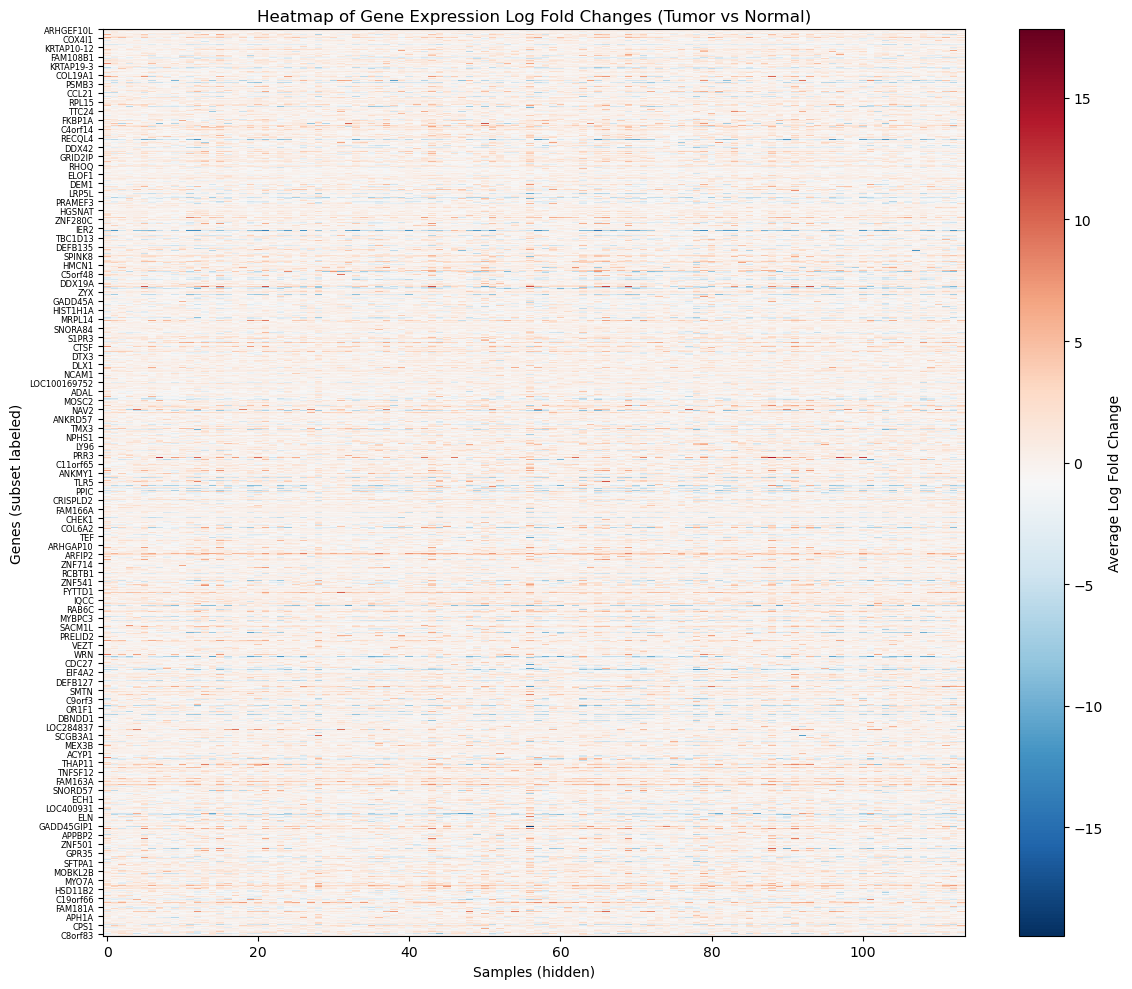

In [79]:
# PLOT (for all genes)
plt.figure(figsize=(12, 10))

# Use interpolation='none' to disable smoothing and preserve exact data values in the heatmap
plt.imshow(feature_matrix.values, aspect='auto', cmap='RdBu_r', interpolation='none')

# Set colorbar (legend)
plt.colorbar(label='Average Log Fold Change')

# Compute how often to show gene names to avoid clutter
yticks_every = max(len(df.index) // 100, 1) # total number of genes (25000) // 100 = 250 -> every 250th gene
                                            # max -> if number of genes < 100 ( len(df.index) // 100 = 0 ) -> fall back to 1 as the minimum spacing

# Set Y-axis ticks (gene name at every 'yticks_every' interval)
plt.yticks(
    ticks=range(0, len(df.index), yticks_every),
    labels=[df.index[i] for i in range(0, len(df.index), yticks_every)],
    fontsize=6
)

plt.xlabel('Samples (hidden)')
plt.ylabel('Genes (subset labeled)')
plt.title('Heatmap of Gene Expression Log Fold Changes (Tumor vs Normal)')
plt.tight_layout()
plt.show()

In [80]:
# Top 100 genes
# Get top 100 genes by average expression
top_100_genes = avg_log_fold_change_df.sort_values(by='avg_log_fold_change', ascending=False).head(100).index

# Subset the feature matrix to only include the top 100 genes
top_100_feature_matrix = feature_matrix.loc[top_100_genes]

# Preview top 100 feature matrix
print("Feature Matrix of top 100 genes by average expression:")
print(top_100_feature_matrix.shape, '\n')
print(top_100_feature_matrix.iloc[:5, :10])

Feature Matrix of top 100 genes by average expression:
(100, 114) 

         TCGA-A7-A0D9  TCGA-BH-A18J  TCGA-BH-A0E1  TCGA-BH-A0HK  TCGA-AC-A2FB  \
sample                                                                          
COL10A1        7.2219        9.2204        7.0967        3.6893        5.7929   
COL11A1        6.8701       11.3260        3.9591        2.9408       -2.3558   
MMP13          6.9908        9.2447        5.6079        3.5282        5.3713   
MMP11          6.5179        9.0169        6.2617        2.5481        4.2792   
CST1           2.7696        3.2307        1.6148        3.3540        3.4229   

         TCGA-BH-A1EO  TCGA-BH-A0BZ  TCGA-BH-A0BC  TCGA-E9-A1N4  TCGA-BH-A0DZ  
sample                                                                         
COL10A1        7.8300        9.9087        7.1129        7.7840       10.2205  
COL11A1        7.5432        9.7427        5.5729        5.5648        7.7627  
MMP13         11.1526        7.8805        6

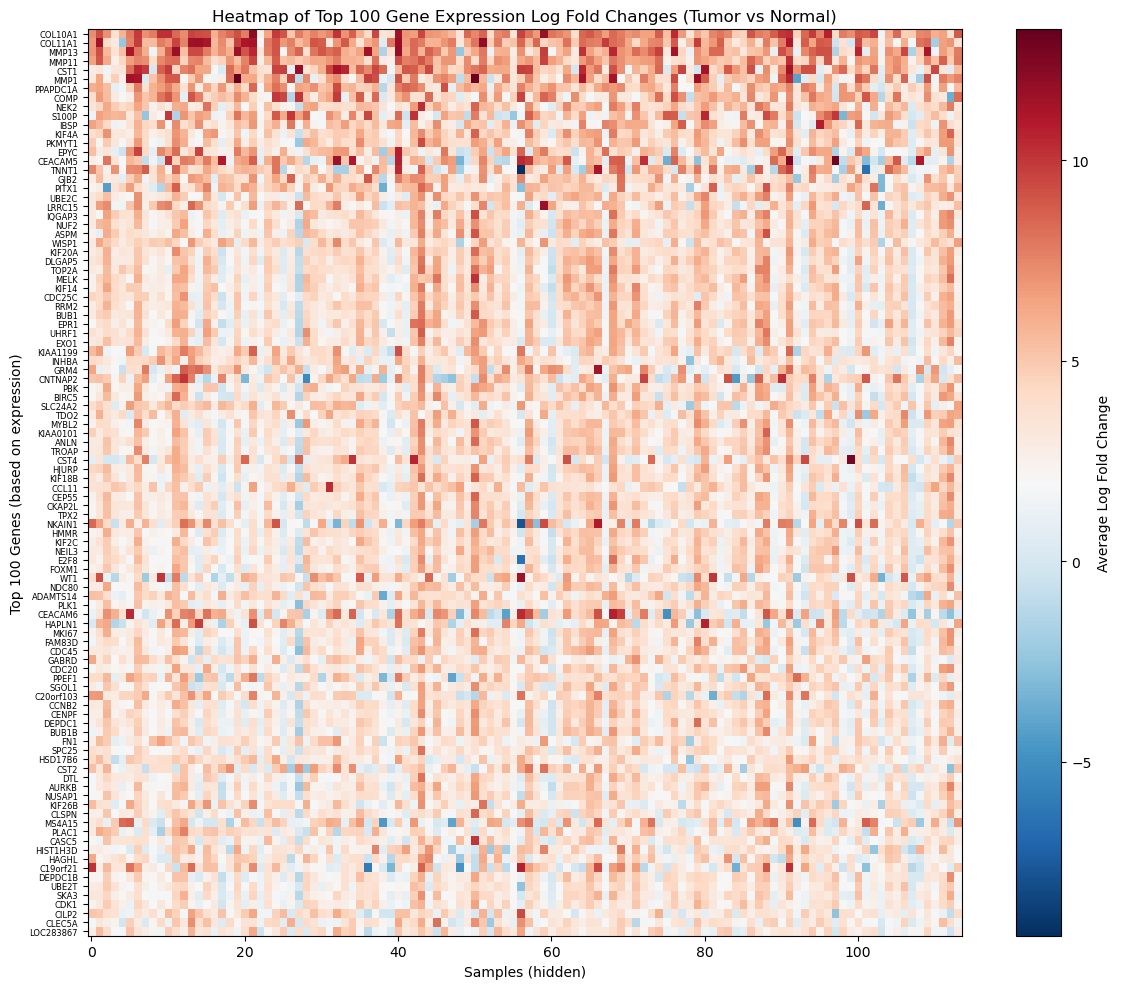

In [81]:
# Plot heatmap for top 100 genes
plt.figure(figsize=(12, 10))

# Use interpolation='none' to disable smoothing and preserve exact data values in the heatmap
plt.imshow(top_100_feature_matrix.values, aspect='auto', cmap='RdBu_r', interpolation='none')

# Set colorbar (legend)
plt.colorbar(label='Average Log Fold Change')

# Compute how often to show gene names to avoid clutter
yticks_every = max(len(top_100_feature_matrix.index) // 100, 1)  # Here, always 1 since we're plotting 100 genes

# Set Y-axis ticks (gene name at every 'yticks_every' interval)
plt.yticks(
    ticks=range(0, len(top_100_feature_matrix.index), yticks_every),
    labels=[top_100_feature_matrix.index[i] for i in range(0, len(top_100_feature_matrix.index), yticks_every)],
    fontsize=6
)

plt.xlabel('Samples (hidden)')
plt.ylabel('Top 100 Genes (based on expression)')
plt.title('Heatmap of Top 100 Gene Expression Log Fold Changes (Tumor vs Normal)')
plt.tight_layout()
plt.show()